In [70]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [71]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [72]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [73]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [74]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [75]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [76]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [78]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(16.7, 20.873214285714287, 23.3)]


In [79]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# You want to take a trip from August 1 to August 7 of this year data set
def stats(start_date='2015-08-01', end_date='2015-08-07'):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()  


# for a year 2015 in the data set
print(stats('2015-08-01', '2015-08-07'))


[(20.6, 25.702272727272728, 29.4)]


8.799999999999997


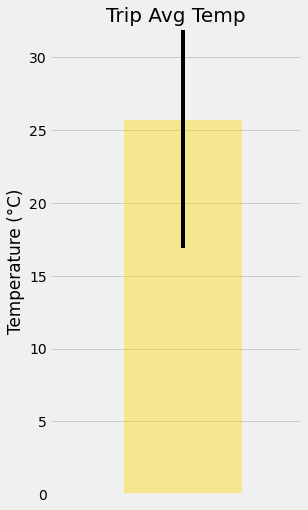

In [80]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Plot variables
from turtle import color


p_to_p = 29.4-20.6
mean_temp_2015 = 25.70
plot_index = 1 

plt.figure(figsize=(4,8))
plt.xticks([])

plt.title("Trip Avg Temp",fontsize=20)
plt.ylabel("Temperature (°C)")
plt.xlim(.10 , 1.8)
plt.ylim(0,32)

plt.bar(plot_index, mean_temp_2015, yerr=p_to_p, color='gold', ecolor="black", align="center", alpha=0.4)

print(p_to_p)

### Daily Rainfall Average

In [81]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Get the stations list
stations = session.query(Station.station)
stations_df = pd.read_sql_query(stations.statement, session.bind)
stations_df.to_dict()


{'station': {0: 'USC00519397',
  1: 'USC00513117',
  2: 'USC00514830',
  3: 'USC00517948',
  4: 'USC00518838',
  5: 'USC00519523',
  6: 'USC00519281',
  7: 'USC00511918',
  8: 'USC00516128'}}

In [82]:
station_prcp = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date >= '2015-08-01').\
        filter(Measurement.date <= '2015-08-07').group_by(Measurement.station)

def rain_perstation(name):
        sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
        return session.query(*sel).filter(Station.station == name).first()

In [83]:
stations_records = []
station_list = ['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281','USC00511918', 'USC00516128']

for record in station_list:
    r=rain_perstation(record)
    stations_records.append(r)
    
# show results 
stations_records

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.914),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 2.133),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 3.627),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 93.447),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 5.943),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84889, 10.027),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.274),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 46.449)]

In [84]:
#create a df of station_results
station_records_df = pd.DataFrame(stations_records)

# create a df of rainfall results
rain_info_df = pd.read_sql_query(station_prcp.statement, session.bind)

rain_info_df.head()

,station,sum_1
0,USC00511918,2.5
1,USC00513117,17.3
2,USC00516128,44.5
3,USC00517948,1.3
4,USC00519281,13.5


In [85]:
# Merge tables & sort this in descending order by precipitation amount, and list the station, name, latitude, longitude, and elevation.

rain_info_df = rain_info_df.rename(columns={'sum_1': 'prec_sum'})
pd.merge(station_records_df, rain_info_df, on="station", how="inner").sort_values(by=["prec_sum"],ascending=False)


,station,name,latitude,longitude,elevation,prec_sum
6,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449,44.5
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,4.450,17.3
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027,13.5
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943,10.2
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914,6.6
5,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.274,2.5
2,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,3.627,1.3


### Daily Temperature Normals

In [86]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(16.7, 20.64230769230769, 25.0)]

In [87]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
date_range

[('2017-08-01',),
 ('2017-08-02',),
 ('2017-08-03',),
 ('2017-08-04',),
 ('2017-08-05',),
 ('2017-08-06',),
 ('2017-08-07',)]

In [88]:
# Create a tuple from the date query "date_range" 
trip_date_range = [x[0] for x in date_range]
trip_date_range

['2017-08-01',
 '2017-08-02',
 '2017-08-03',
 '2017-08-04',
 '2017-08-05',
 '2017-08-06',
 '2017-08-07']

In [89]:
# Strip off the year and save a list of strings in the format %m-%d
trip_dates_stripped= [x[5:] for x in trip_date_range]
trip_dates_stripped

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [90]:
# Use the `daily_normals` function to calculate the normals for each date string 

daily_normals = [session.query
    (func.avg(Measurement.tobs),
    func.min(Measurement.tobs),
    func.max(Measurement.tobs)).\
        filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
        filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
        group_by(func.strftime("%m-%d", Measurement.date)).all()]

# and append the results to a list called `normals`.
normals = daily_normals[0]
normals

[(24.186, 19.4, 28.3),
 (24.220754716981123, 20.0, 28.9),
 (24.77777777777778, 21.1, 29.4),
 (24.84038461538462, 20.6, 28.9),
 (24.529629629629632, 20.6, 27.8),
 (24.582142857142852, 19.4, 28.3),
 (25.08235294117647, 21.7, 28.3)]

In [91]:
# Load the previous query results into a Pandas DataFrame and 
trip_daily_normals_df= pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])

# add the `trip_dates` range as the `date` index
trip_daily_normals_df['date']= trip_date_range
print(trip_daily_normals_df)

        tmin  tavg  tmax        date
0  24.186000  19.4  28.3  2017-08-01
1  24.220755  20.0  28.9  2017-08-02
2  24.777778  21.1  29.4  2017-08-03
3  24.840385  20.6  28.9  2017-08-04
4  24.529630  20.6  27.8  2017-08-05
5  24.582143  19.4  28.3  2017-08-06
6  25.082353  21.7  28.3  2017-08-07


In [92]:
# Change datatype from element to datetime object on Pandas, makes x axis title to add 
trip_daily_normals_df['date'] = pd.to_datetime(trip_daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
trip_daily_normals_df.set_index('date',inplace=True)

trip_daily_normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,24.186000,19.4,28.3
2017-08-02,24.220755,20.0,28.9
2017-08-03,24.777778,21.1,29.4
2017-08-04,24.840385,20.6,28.9
2017-08-05,24.529630,20.6,27.8
2017-08-06,24.582143,19.4,28.3
2017-08-07,25.082353,21.7,28.3


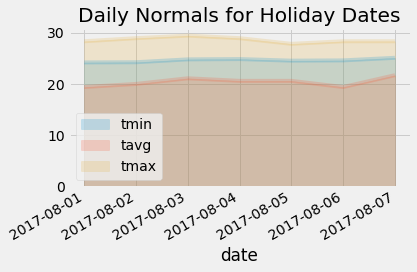

In [93]:
# Plot the daily normals as an area plot with `stacked=False`

# Plot the daily normals as an area plot with `stacked=False`
trip_daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Daily Normals for Holiday Dates")
plt.tight_layout()
plt.show()


## Close Session

In [94]:
session.close()